<a href="https://colab.research.google.com/github/harish678/Audio-Processing/blob/master/Music_Genre_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Music genre classification notebook

## Importing Libraries

In [0]:
# feature extractoring and preprocessing data
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## Extracting music and features

### Dataset

We use [GTZAN genre collection](http://opihi.cs.uvic.ca/sound/genres.tar.gz) dataset for classification. 
<br>
<br>
The dataset consists of 10 genres i.e
 * Blues
 * Classical
 * Country
 * Disco
 * Hiphop
 * Jazz
 * Metal
 * Pop
 * Reggae
 * Rock
 
Each genre contains 100 songs. Total dataset: 1000 songs

## Extracting the Spectrogram for every Audio

In [0]:
cmap = plt.get_cmap('inferno')

plt.figure(figsize=(10,10))
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in genres:
    pathlib.Path(f'img_data/{g}').mkdir(parents=True, exist_ok=True)     
    for filename in os.listdir(f'./MIR/genres/{g}'):
        songname = f'./MIR/genres/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=5)
        plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB');
        plt.axis('off');
        plt.savefig(f'img_data/{g}/{filename[:-3].replace(".", "")}.png')
        plt.clf()
 

All the audio files get converted into their respective spectrograms .WE can now easily extract features from them.

## Extracting features from Spectrogram


We will extract

* Mel-frequency cepstral coefficients (MFCC)(20 in number)
* Spectral Centroid,
* Zero Crossing Rate
* Chroma Frequencies
* Spectral Roll-off.

In [0]:
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

## Writing data to csv file

We write the data to a csv file 

In [0]:
file = open('data.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in genres:
    for filename in os.listdir(f'./MIR/genres/{g}'):
        songname = f'./MIR/genres/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=30)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {g}'
        file = open('data.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

The data has been extracted into a data.csv file.

# Analysing the Data in Pandas

In [2]:
data = pd.read_csv('data.csv')
data.head()

,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,blues.00081.au,0.380260,0.248262,2116.942959,1956.611056,4196.107960,0.127272,-26.929785,107.334008,-46.809993,...,14.336612,-13.821769,7.562789,-6.181372,0.330165,-6.829571,0.965922,-7.570825,2.918987,blues
1,blues.00022.au,0.306451,0.113475,1156.070496,1497.668176,2170.053545,0.058613,-233.860772,136.170239,3.289490,...,-2.250578,3.959198,5.322555,0.812028,-1.107202,-4.556555,-2.436490,3.316913,-0.608485,blues
2,blues.00031.au,0.253487,0.151571,1331.073970,1973.643437,2900.174130,0.042967,-221.802549,110.843071,18.620984,...,-13.037723,-12.652228,-1.821905,-7.260097,-6.660252,-14.682694,-11.719264,-11.025216,-13.387260,blues
3,blues.00012.au,0.269320,0.119072,1361.045467,1567.804596,2739.625101,0.069124,-207.208080,132.799175,-15.438986,...,-0.613248,0.384877,2.605128,-5.188924,-9.527455,-9.244394,-2.848274,-1.418707,-5.932607,blues
4,blues.00056.au,0.391059,0.137728,1811.076084,2052.332563,3927.809582,0.075480,-145.434568,102.829023,-12.517677,...,7.457218,-10.470444,-2.360483,-6.783624,2.671134,-4.760879,-0.949005,0.024832,-2.005315,blues


In [3]:
data.shape

(1000, 28)

In [0]:
# Dropping unneccesary columns
data = data.drop(['filename'],axis=1)

## Encoding the Labels

In [0]:
genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)

## Scaling the Feature columns

In [0]:
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

## Dividing data into training and Testing set

In [0]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2)

# Classification with Keras

## Building our Network

In [8]:
import keras
from keras.layers import *
from keras.callbacks import *
from keras.models import Model

Using TensorFlow backend.


In [0]:
def make_model():
    inp = Input(shape=(X.shape[1],))
    x = Dense(512, activation="relu")(inp)
    x = Dense(256, activation="relu")(x)
    x = Dense(128, activation="relu")(x)
    x = Dense(64, activation="relu")(x)
    x = Dense(10, activation="softmax")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(X))
y_preds = np.zeros((len(X_test), 10))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y)):
    print("fold n°{}".format(fold_))
    X_train, y_train = (X[trn_idx], y[trn_idx])
    X_valid, y_valid = (X[val_idx], y[val_idx])
    
    clf = make_model()
    chk = ModelCheckpoint("best_weight.wt", monitor='val_acc', mode = 'max', save_best_only = True, verbose = 0)
    clf.fit(X_train, y_train, validation_data = [X_valid, y_valid],  batch_size=64, epochs=45, verbose=0, callbacks = [chk])
    clf.load_weights("best_weight.wt")
    oof[val_idx] = np.argmax(clf.predict(X_valid), axis=1)
    score = accuracy_score(oof[val_idx], y_valid)
    print(f'Scored {score:.3f} on validation data')
    
    y_preds += clf.predict(X_test)

fold n°0
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Scored 0.669 on validation data
fold n°1
Scored 0.728 on validation data
fold n°2
Scored 0.713 on validation data
fold n°3
Scored 0.652 on validation data
fold n°4
Scored 0.650 on validation data


In [11]:
print(f'Local CV is {accuracy_score(oof, y): .4f}')

Local CV is  0.6825


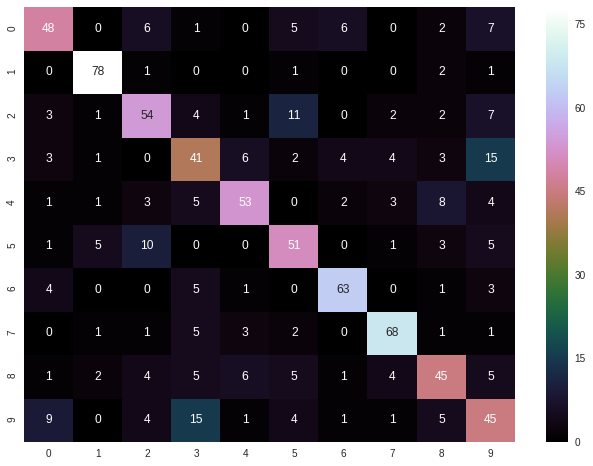

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y, oof)
plt.figure(figsize=(11,8))
sns.heatmap(cm, annot=True, cmap="cubehelix", fmt='g')
plt.show()

## Predictions on Test Data

In [0]:
y_preds = np.argmax(y_preds, axis=1)

In [0]:
y_preds = encoder.inverse_transform(y_preds)

In [21]:
print(f'Test Accuracy: {accuracy_score(y_test, encoder.transform(y_preds)): .4f}')

Test Accuracy:  0.7100


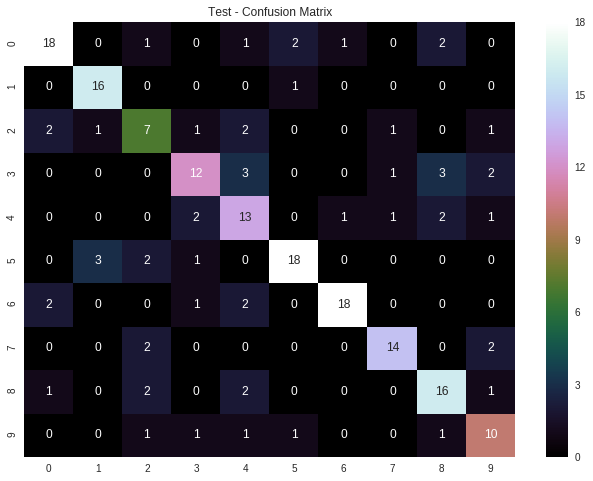

In [22]:
cm = confusion_matrix(y_test, encoder.transform(y_preds))
plt.figure(figsize=(11,8))
sns.heatmap(cm, annot=True, cmap="cubehelix", fmt='g')
plt.title('Test - Confusion Matrix')
plt.show()